In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dataset import load_CIFAR10 

# ----------------- 数据准备 -----------------
# 设置随机种子
np.random.seed(0)

# 加载 CIFAR-10 数据
data_dir = './cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(data_dir)

# 数据归一化
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# 划分验证集：取前5000个样本作为验证集，其余作为训练集
num_val = 5000
X_val = X_train[:num_val]
y_val = y_train[:num_val]
X_train_new = X_train[num_val:]
y_train_new = y_train[num_val:]

# 将图像展平为向量
input_size = 32 * 32 * 3  # 3072
X_train_new = X_train_new.reshape(X_train_new.shape[0], -1)
X_val = X_val.reshape(X_val.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)


In [2]:
class MLP:
    def __init__(self, input_size, hidden_sizes, output_size):
        """
        初始化网络参数，hidden_sizes 为列表，例如 [512]、[512, 256]、[512,256,128]
        """
        # 总层数：len(hidden_sizes)+1（最后一层为输出层）
        self.num_layers = len(hidden_sizes) + 1
        self.weights = []
        self.biases = []
        # 定义每一层的输入和输出大小
        layer_sizes = [input_size] + hidden_sizes + [output_size]
        for i in range(len(layer_sizes)-1):
            # 使用 He 初始化（适用于 ReLU 激活）
            W = np.random.randn(layer_sizes[i], layer_sizes[i+1]) * np.sqrt(2.0 / layer_sizes[i])
            b = np.zeros((1, layer_sizes[i+1]))
            self.weights.append(W)
            self.biases.append(b)

    def forward(self, X):
        """
        前向传播：保存每层的输入（a）和线性变换结果（z）
        对隐藏层使用 ReLU 激活，输出层直接输出 logits
        """
        self.cache = {}
        a = X
        self.cache['a0'] = a
        L = self.num_layers
        for i in range(L):
            z = a.dot(self.weights[i]) + self.biases[i]
            self.cache['z' + str(i+1)] = z
            # 隐藏层使用 ReLU 激活
            if i < L - 1:
                a = np.maximum(0, z)
            else:
                a = z  # 输出层不做激活
            self.cache['a' + str(i+1)] = a
        return a

    def softmax(self, logits):
        # 数值稳定性处理
        exp_logits = np.exp(logits - np.max(logits, axis=1, keepdims=True))
        probs = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)
        return probs

    def compute_loss_and_grad(self, X, y):
        """
        计算前向传播、交叉熵损失以及输出层梯度（梯度已归一化）
        """
        logits = self.forward(X)  # shape: (N, C)
        probs = self.softmax(logits)
        N = X.shape[0]
        # 交叉熵损失
        loss = -np.sum(np.log(probs[np.arange(N), y] + 1e-7)) / N
        # 计算梯度：对正确类别减1
        grad_logits = probs.copy()
        grad_logits[np.arange(N), y] -= 1
        grad_logits /= N
        return loss, grad_logits

    def backward(self, grad_logits):
        """
        反向传播：计算所有层参数的梯度
        """
        grads_W = [None] * self.num_layers
        grads_b = [None] * self.num_layers
        L = self.num_layers
        # 从输出层开始传播梯度
        delta = grad_logits
        for i in reversed(range(L)):
            a_prev = self.cache['a' + str(i)]
            grads_W[i] = a_prev.T.dot(delta)
            grads_b[i] = np.sum(delta, axis=0, keepdims=True)
            if i > 0:
                # 反向传播通过 ReLU 激活
                z = self.cache['z' + str(i)]
                delta = delta.dot(self.weights[i].T) * (z > 0)
        return grads_W, grads_b

    def update_params(self, grads_W, grads_b, learning_rate):
        for i in range(self.num_layers):
            self.weights[i] -= learning_rate * grads_W[i]
            self.biases[i] -= learning_rate * grads_b[i]

    def predict(self, X):
        logits = self.forward(X)
        probs = self.softmax(logits)
        preds = np.argmax(probs, axis=1)
        return preds

In [3]:
def train_model(model, X_train, y_train, X_val, y_val, num_epochs=20, batch_size=128, learning_rate=1e-3):
    N = X_train.shape[0]
    num_batches = int(np.ceil(N / batch_size))
    train_losses = []
    val_accuracies = []
    for epoch in range(num_epochs):
        # 打乱数据
        indices = np.arange(N)
        np.random.shuffle(indices)
        X_train = X_train[indices]
        y_train = y_train[indices]
        epoch_loss = 0.0
        for i in range(num_batches):
            start = i * batch_size
            end = min(N, (i + 1) * batch_size)
            X_batch = X_train[start:end]
            y_batch = y_train[start:end]
            loss, grad_logits = model.compute_loss_and_grad(X_batch, y_batch)
            epoch_loss += loss * (end - start)
            grads_W, grads_b = model.backward(grad_logits)
            model.update_params(grads_W, grads_b, learning_rate)
        epoch_loss /= N
        train_losses.append(epoch_loss)
        # 在验证集上计算准确率
        preds = model.predict(X_val)
        val_acc = np.mean(preds == y_val)
        val_accuracies.append(val_acc)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Val Acc: {val_acc:.4f}")
    return train_losses, val_accuracies


In [4]:
# ----------------- 实验设置 -----------------
# 三种不同的隐藏层配置
model_configs = {
    "1-hidden": [384],
    "2-hidden": [384, 192],
    "3-hidden": [384, 192, 96]
}

num_epochs = 100
learning_rate = 1e-3
batch_size = 200

# 用于保存不同模型的训练历史
history = {}

for config_name, hidden_sizes in model_configs.items():
    print("\n训练模型配置：", config_name)
    model = MLP(input_size, hidden_sizes, output_size=10)
    train_loss, val_acc = train_model(model, X_train_new, y_train_new, X_val, y_val,
                                      num_epochs=num_epochs, batch_size=batch_size, learning_rate=learning_rate)
    history[config_name] = {"loss": train_loss, "acc": val_acc}



训练模型配置： 1-hidden
Epoch 1/100, Loss: 2.2318, Val Acc: 0.2310
Epoch 2/100, Loss: 2.1118, Val Acc: 0.2528
Epoch 3/100, Loss: 2.0534, Val Acc: 0.2752
Epoch 4/100, Loss: 2.0136, Val Acc: 0.2898
Epoch 5/100, Loss: 1.9837, Val Acc: 0.2988
Epoch 6/100, Loss: 1.9599, Val Acc: 0.3146
Epoch 7/100, Loss: 1.9408, Val Acc: 0.3226
Epoch 8/100, Loss: 1.9243, Val Acc: 0.3296
Epoch 9/100, Loss: 1.9100, Val Acc: 0.3372
Epoch 10/100, Loss: 1.8972, Val Acc: 0.3400
Epoch 11/100, Loss: 1.8857, Val Acc: 0.3442
Epoch 12/100, Loss: 1.8753, Val Acc: 0.3484
Epoch 13/100, Loss: 1.8659, Val Acc: 0.3538
Epoch 14/100, Loss: 1.8572, Val Acc: 0.3550
Epoch 15/100, Loss: 1.8492, Val Acc: 0.3570
Epoch 16/100, Loss: 1.8416, Val Acc: 0.3606
Epoch 17/100, Loss: 1.8348, Val Acc: 0.3622
Epoch 18/100, Loss: 1.8281, Val Acc: 0.3628
Epoch 19/100, Loss: 1.8220, Val Acc: 0.3654
Epoch 20/100, Loss: 1.8162, Val Acc: 0.3700
Epoch 21/100, Loss: 1.8106, Val Acc: 0.3686
Epoch 22/100, Loss: 1.8055, Val Acc: 0.3712
Epoch 23/100, Loss: 1.8

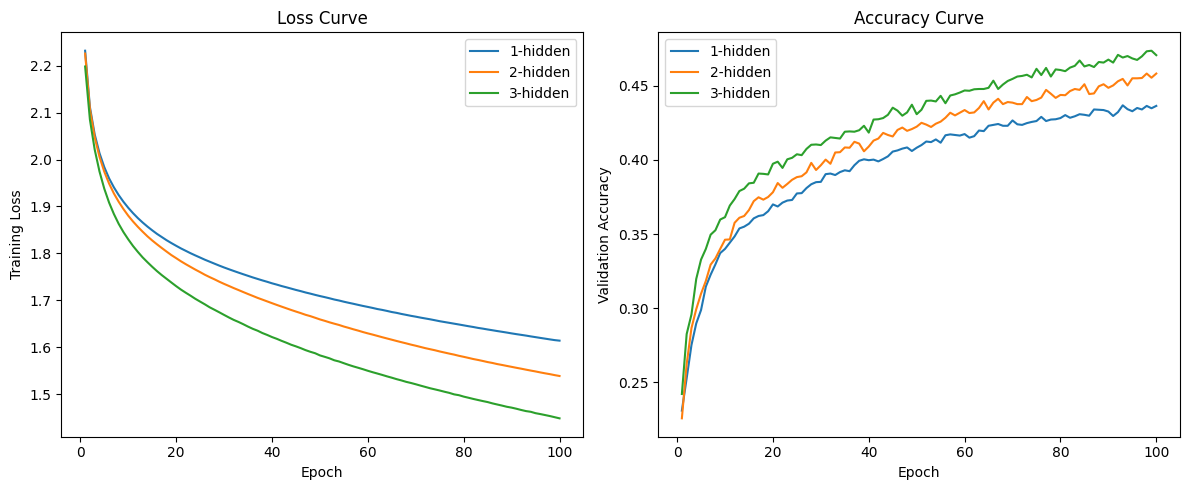

In [5]:
# ----------------- 绘图 -----------------
epochs = np.arange(1, num_epochs + 1)
plt.figure(figsize=(12, 5))

# 绘制训练 loss 曲线
plt.subplot(1, 2, 1)
for config_name in model_configs.keys():
    plt.plot(epochs, history[config_name]["loss"], label=config_name)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Loss Curve")
plt.legend()

# 绘制验证 accuracy 曲线
plt.subplot(1, 2, 2)
for config_name in model_configs.keys():
    plt.plot(epochs, history[config_name]["acc"], label=config_name)
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Accuracy Curve")
plt.legend()

plt.tight_layout()
plt.show()
